In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

Using TensorFlow backend.


In [3]:
disease_types = ['Apple,Black_Rot','Apple,Cedar_Rust','Apple,Healthy','Apple,Scab','Blueberry,Healthy','Cherry(Including_Sour),Healthy','Cherry(Including_Sour),Powdery_Mildew','Corn(Maize),Cercospora_Gray_leaf_spot','Corn(Maize),Common_Rust','Corn(Maize),Northern_Leaf_Blight','Corn(Maize),healthy','Grape,Black_Rot','Grape,Esca_(Black_Measles)','Grape,Healthy','Grape,Leaf_Blight_(Isariopsis_Leaf_Spot)','Misc','Orange,Haunglongbing_(Citrus_Greening)','Peach,Bacterial_Spot','Peach,Healthy','Pepper,Bell_Bacterial_Spot','Pepper,Healthy','Potato,Early_blight','Potato,Healthy','Potato,Late_Blight','Raspberry,Healthy','Soybean,Healthy','Squash,Powdery_Mildew','Strawberry,Healthy','Strawberry,Leaf_Scorch','Tomato,Bacterial_Spot','Tomato,Early_Blight','Tomato,Healthy','Tomato,Late_Blight','Tomato,Leaf_Mold','Tomato,Mosaic_Virus','Tomato,Septoria_leaf_Spot','Tomato,Spider_Mite','Tomato,Target_Spot','Tomato,Yellow_Leaf_Curl_Virus']
data_dir = '../input/plantvillage/PlantVillage/train'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [4]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
44011,"Tomato,Yellow_Leaf_Curl_Virus/ce2901f4-99fe-49...",38,"Tomato,Yellow_Leaf_Curl_Virus"
44012,"Tomato,Yellow_Leaf_Curl_Virus/3e429770-8b09-4f...",38,"Tomato,Yellow_Leaf_Curl_Virus"
44013,"Tomato,Yellow_Leaf_Curl_Virus/f6ede3fd-70e1-40...",38,"Tomato,Yellow_Leaf_Curl_Virus"
44014,"Tomato,Yellow_Leaf_Curl_Virus/fdcb2e51-140c-4e...",38,"Tomato,Yellow_Leaf_Curl_Virus"
44015,"Tomato,Yellow_Leaf_Curl_Virus/c750dcd7-c262-44...",38,"Tomato,Yellow_Leaf_Curl_Virus"


In [5]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,"Tomato,Yellow_Leaf_Curl_Virus/1b55735a-c10e-4e...",38,"Tomato,Yellow_Leaf_Curl_Virus"
1,"Tomato,Spider_Mite/85b0921b-3d9a-4578-a389-6e4...",36,"Tomato,Spider_Mite"
2,"Squash,Powdery_Mildew/fddc3059-31d4-4024-a69b-...",26,"Squash,Powdery_Mildew"
3,"Tomato,Healthy/e8ccc10e-1991-4cd9-8419-fc3857f...",31,"Tomato,Healthy"
4,"Tomato,Healthy/6f5b57d9-46c8-41b6-9f79-eda044f...",31,"Tomato,Healthy"


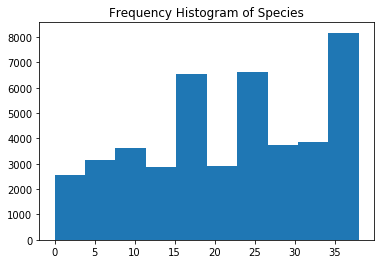

<Figure size 864x864 with 0 Axes>

In [6]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

In [ ]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Tomato_Bacterial_spot', 5, 5)

In [7]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [8]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

44016it [03:13, 227.41it/s]


Train Shape: (44016, 64, 64, 3)


In [10]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=39)

In [11]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

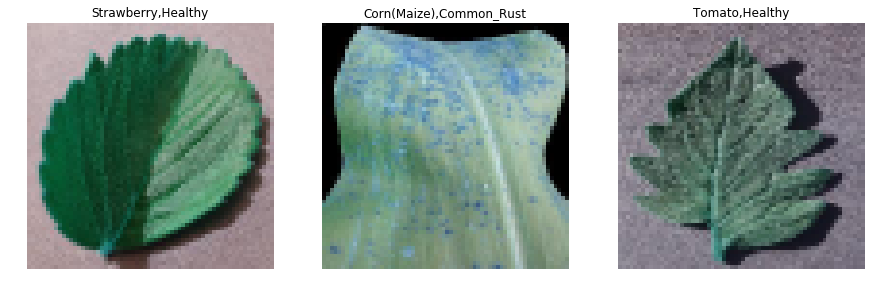

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [13]:
EPOCHS = 20
SIZE=64
N_ch=3

In [14]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(39,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [15]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2624